# Jupyter Notebook para el entrenamiento de modelos ML de Clasificación que determinen si un vuelo va a tener retraso o no

# Instalaciones

In [ ]:
# %pip install imbalanced-learn
# !pip install --upgrade imbalanced-learn scikit-learn
# !pip install -U imbalanced-learn
# !pip install -U scikit-learn

# Importaciones

In [ ]:
import joblib

In [1]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Store the classifier models to save time
import joblib

# Preprocessing
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split as tts
from imblearn.over_sampling import SMOTE

# Classifiers from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb

# Performance metrics
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import precision_score as prec
from sklearn.metrics import recall_score as rec
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix as cm


from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend

In [2]:
fl = pd.read_csv("../data/ML/clean_data_for_ML.csv")

# Preparación de variables para el modelo

In [3]:
fl = fl[fl.duration.notna()]

In [4]:
fl.columns

Index(['arr_mins_of_delay', 'week_day', 'week_num', 'day_time',
       'cod_flight_IATA', 'cod_airliner_IATA', 'cod_airport_IATA', 'duration',
       'Temperature', 'Wind', 'acc_Gusts', 'Relative_hum', 'Pressure',
       'Condition', 'acc_bad_weather'],
      dtype='object')

## Elimino columnas de baja correlación o con demasiados valores que pueden provocar overfitting en los modelos

In [5]:
fl = fl.drop(columns = ['cod_flight_IATA','Relative_hum','Pressure','cod_airport_IATA'])

## Genero la variable target "Delayed"

In [6]:
fl['Delayed'] = fl['arr_mins_of_delay'].apply(lambda x: 1 if x > 0 else 0)

0    0.672649
1    0.327351
Name: Delayed, dtype: float64

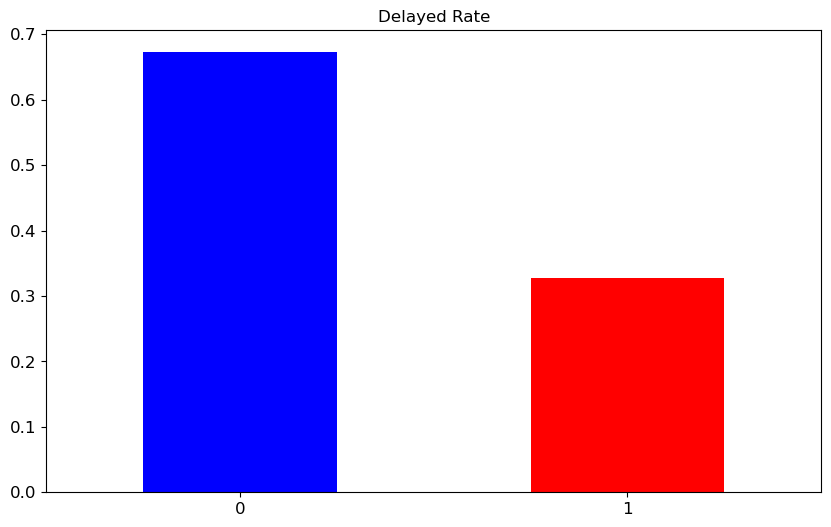

In [7]:
(fl.Delayed.value_counts()/len(fl)).plot.bar(color=['b', 'r'],    # plot customer churn rate
                                           figsize=(10, 6),
                                           title='Delayed Rate',
                                           rot=0,
                                           fontsize=12);


fl.Delayed.value_counts()/len(fl)

## Correlaciones

In [8]:
corr=fl.corr()   # correlation matrix

corr

C:\Users\daarr\AppData\Local\Temp\ipykernel_22008\3013328059.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=fl.corr()   # correlation matrix


,arr_mins_of_delay,week_num,duration,Temperature,Wind,acc_Gusts,acc_bad_weather,Delayed
arr_mins_of_delay,1.000000,0.010288,-0.025159,0.051942,0.077659,0.082185,0.075111,0.621259
week_num,0.010288,1.000000,0.007501,0.178952,-0.036482,-0.010524,0.023384,0.016726
duration,-0.025159,0.007501,1.000000,0.032352,0.000747,-0.010846,-0.001045,0.040115
Temperature,0.051942,0.178952,0.032352,1.000000,0.148810,0.139241,-0.127939,0.065140
Wind,0.077659,-0.036482,0.000747,0.148810,1.000000,0.574136,0.043563,0.089730
acc_Gusts,0.082185,-0.010524,-0.010846,0.139241,0.574136,1.000000,0.023857,0.090510
acc_bad_weather,0.075111,0.023384,-0.001045,-0.127939,0.043563,0.023857,1.000000,0.063781
Delayed,0.621259,0.016726,0.040115,0.065140,0.089730,0.090510,0.063781,1.000000


## Cambio la columna week_num a categórica

In [9]:
fl['week_num'] = fl['week_num'].astype('object')

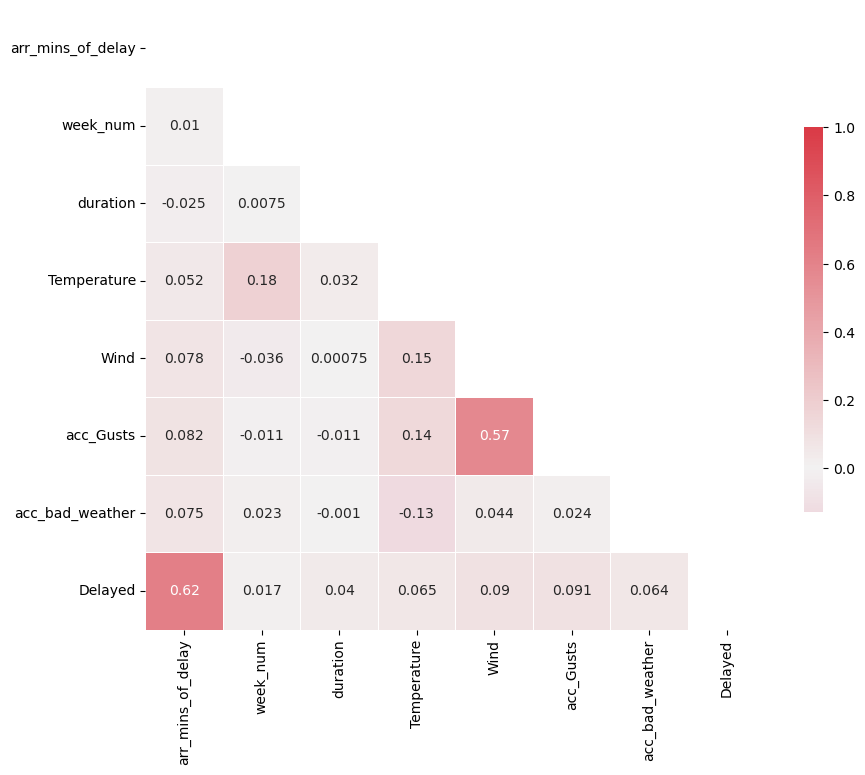

In [10]:
fig, ax=plt.subplots(figsize=(10,10))


mask=np.triu(np.ones_like(corr, dtype=bool))           # mask for superior triangular matrix


color_map=sns.diverging_palette(0, 10, as_cmap=True)   # color palette


# correlation heatmap
sns.heatmap(corr,                       # data
            mask=mask,                  # white mask
            cmap=color_map,             # color
            vmax=1,                     # vertical edge
            center=0,                   # plot center
            square=True,                # data square representation
            annot=True,
            linewidth=.5,               # linewidth
            cbar_kws={'shrink': .5},    # lateral bar legend
            ax=ax                       # axes for plot size
           );

In [11]:
fl = fl.drop(columns = ['arr_mins_of_delay'])

## One Hot Encoding

In [12]:
fl=pd.get_dummies(fl, columns = ['week_num','Condition','week_day','day_time','cod_airliner_IATA'], drop_first=True)


C:\Users\daarr\AppData\Local\Temp\ipykernel_22008\2196711668.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  fl=pd.get_dummies(fl, columns = ['week_num','Condition','week_day','day_time','cod_airliner_IATA'], drop_first=True)


In [13]:
fl.Delayed.value_counts()

0    592426
1    288310
Name: Delayed, dtype: int64

In [14]:
fl.shape

(880736, 184)

In [73]:
listacols = list(fl.columns)

In [74]:
listacols

['duration',
 'Temperature',
 'Wind',
 'acc_Gusts',
 'acc_bad_weather',
 'Delayed',
 'week_num_1',
 'week_num_2',
 'week_num_3',
 'week_num_4',
 'week_num_5',
 'week_num_6',
 'week_num_7',
 'week_num_8',
 'week_num_9',
 'week_num_10',
 'week_num_11',
 'week_num_12',
 'week_num_13',
 'week_num_14',
 'week_num_15',
 'week_num_16',
 'week_num_17',
 'week_num_18',
 'week_num_19',
 'week_num_20',
 'week_num_21',
 'week_num_22',
 'week_num_23',
 'week_num_24',
 'week_num_25',
 'week_num_26',
 'week_num_27',
 'week_num_28',
 'week_num_29',
 'week_num_30',
 'week_num_31',
 'week_num_32',
 'week_num_33',
 'week_num_34',
 'week_num_35',
 'week_num_36',
 'week_num_37',
 'week_num_38',
 'week_num_39',
 'week_num_40',
 'week_num_41',
 'week_num_42',
 'week_num_43',
 'week_num_44',
 'week_num_45',
 'week_num_46',
 'week_num_47',
 'week_num_48',
 'week_num_49',
 'week_num_50',
 'week_num_51',
 'week_num_52',
 'week_num_53',
 'Condition_Chance of Showers',
 'Condition_Clear',
 'Condition_Cloudy',
 'Co

# División del DataFrame para el entrenamiento

In [15]:
X = fl.drop('Delayed', axis=1)
y = fl.Delayed

In [16]:
X.shape, y.shape

((880736, 183), (880736,))

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880736 entries, 0 to 880761
Columns: 183 entries, duration to cod_airliner_IATA_YW
dtypes: float64(3), int64(2), uint8(178)
memory usage: 189.8 MB


In [18]:
# stratify mantiene la distribucion del objetivo
X_train, X_test, y_train, y_test = tts(X, y, 
                                       random_state=42,
                                       stratify=y)

# Normalización de las variables numéricas

In [19]:
escalador = StandardScaler()    # inicia el normalizador

X_train[['duration','Temperature', 'Wind', 'acc_Gusts','acc_bad_weather']] = escalador.fit_transform(X_train[['duration','Temperature', 'Wind', 'acc_Gusts','acc_bad_weather']])   # transforma train
X_test[['duration','Temperature', 'Wind', 'acc_Gusts','acc_bad_weather']] = escalador.transform(X_test[['duration','Temperature', 'Wind', 'acc_Gusts','acc_bad_weather']])  # transforma test

# Aplico SMOTE (Synthetic Minority over-sampling Technique) para equilibrar la diferencia entre clases

In [20]:
# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [21]:
X_train.shape

(660552, 183)

In [22]:
X_resampled.shape

(888638, 183)

# Ensayo de diferentes modelos de regresión

# Logistic Regression

In [ ]:
# logreg = LogisticRegression(n_jobs=8)


In [ ]:
# logreg.fit(X_train, y_train)

In [ ]:
# y_pred_logreg = logreg.predict(X_test)

# y_pred_logreg[:10]

In [ ]:
# y_test.head(10)


In [ ]:
# print("Score: ",logreg.score(X_test, y_test))
# print("Precission: ",prec(y_test, y_pred_logreg))
# print("Accuracy: ",acc(y_test, y_pred_logreg))
# print("Recall: ",rec(y_test, y_pred_logreg))
# print("F1: ",f1(y_test, y_pred_logreg))

In [ ]:
# y_test.value_counts() / y_test.shape[0] * 100

In [ ]:
# y_prob = logreg.predict_proba(X_test)
# y_prob[:10]

In [ ]:
# y_pred_logreg2 = [1 if e[1]>0.3 else 0 for e in y_prob]

# sum(y_pred_logreg2==y_test) / len(y_pred_logreg2) * 100   # acierto, accuracy

In [ ]:
# sum(y_pred_logreg2)

In [ ]:
# cm(y_test, y_pred_logreg2)
# cm(y_test, y_pred_logreg2)/cm(y_test, y_pred_logreg2).sum()*100
# plt.figure(figsize=(15, 8))

# ax=sns.heatmap(cm(y_test, y_pred_logreg2)/cm(y_test, y_pred_logreg2).sum() * 100, 
#                annot=True)

# plt.title('Matriz confusion')
# plt.ylabel('Verdad')
# plt.xlabel('Prediccion')
# plt.show();

# XGBOOST

In [ ]:
# xgbc = xgb.XGBClassifier(n_jobs = 8)

In [ ]:
# xgbc.fit(X_train, y_train)

In [ ]:
# y_pred_xgb = xgbc.predict(X_test)

# y_pred_xgb[:10]

In [ ]:
# print("Score: ",xgbc.score(X_test, y_test))
# print("Precission: ",prec(y_test, y_pred_xgb))
# print("Accuracy: ",acc(y_test, y_pred_xgb))
# print("Recall: ",rec(y_test, y_pred_xgb))
# print("F1: ",f1(y_test, y_pred_xgb))

In [ ]:
# y_prob = xgbc.predict_proba(X_test)

In [ ]:
# y_prob[:10]

In [ ]:
# y_test.head(10)

In [ ]:
# y_pred_xgb.sum()

In [ ]:
# cm(y_test, y_pred_xgb)
# cm(y_test, y_pred_xgb)/cm(y_test, y_pred_xgb).sum()*100
# plt.figure(figsize=(15, 8))

# ax=sns.heatmap(cm(y_test, y_pred_xgb)/cm(y_test, y_pred_xgb).sum() * 100, 
#                annot=True)

# plt.title('Matriz confusion')
# plt.ylabel('Verdad')
# plt.xlabel('Prediccion')

# RandomForestClassifier

In [23]:
rfc = RandomForestClassifier(n_estimators=200,
                             min_samples_split=5,
                             min_samples_leaf=2,
                             n_jobs=8)


In [24]:
rfc.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=8)

In [ ]:
# rfc.fit(X_train, y_train)

In [25]:
y_pred_rfc = rfc.predict(X_test)

y_pred_rfc[:10]

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0], dtype=int64)

In [26]:
y_test.head(10)

50135     0
307634    0
103637    1
508712    0
72626     1
662607    0
806215    0
593930    0
459207    1
227302    0
Name: Delayed, dtype: int64

In [27]:
print("Score: ",rfc.score(X_test, y_test))
print("Precission: ",prec(y_test, y_pred_rfc))
print("Accuracy: ",acc(y_test, y_pred_rfc))
print("Recall: ",rec(y_test, y_pred_rfc))
print("F1: ",f1(y_test, y_pred_rfc))

Score:  0.6846001525996439
Precission:  0.5192237436249653
Accuracy:  0.6846001525996439
Recall:  0.4929589189339179
F1:  0.505750562245566


In [29]:
y_prob = rfc.predict_proba(X_test)

In [30]:
y_test.head(10)

50135     0
307634    0
103637    1
508712    0
72626     1
662607    0
806215    0
593930    0
459207    1
227302    0
Name: Delayed, dtype: int64

In [31]:
y_prob[:10]

array([[0.63876068, 0.36123932],
       [0.62908628, 0.37091372],
       [0.35270019, 0.64729981],
       [0.49364773, 0.50635227],
       [0.4183207 , 0.5816793 ],
       [0.78152826, 0.21847174],
       [0.79621087, 0.20378913],
       [0.70930076, 0.29069924],
       [0.29681702, 0.70318298],
       [0.77584167, 0.22415833]])

In [32]:
print(sum(y_pred_rfc))
print(sum(y_test))

68431
72077


# Cambio el umbral de decisión para aumentar el recall

In [51]:
y_pred_rfc2 = [1 if e[1]>0.32 else 0 for e in y_prob]

In [52]:
sum(y_pred_rfc2)

141262

In [53]:
print("Precission: ",prec(y_test, y_pred_rfc2))
print("Accuracy: ",acc(y_test, y_pred_rfc2))
print("Recall: ",rec(y_test, y_pred_rfc2))
print("F1: ",f1(y_test, y_pred_rfc2))

Precission:  0.410358058076482
Accuracy:  0.5576290738654943
Recall:  0.8042510093372366
F1:  0.5434355649928049


In [54]:
sum(y_pred_rfc2)/len(y_pred_rfc2)

0.641563419685354

# Matriz de confusión con cambio de umbral

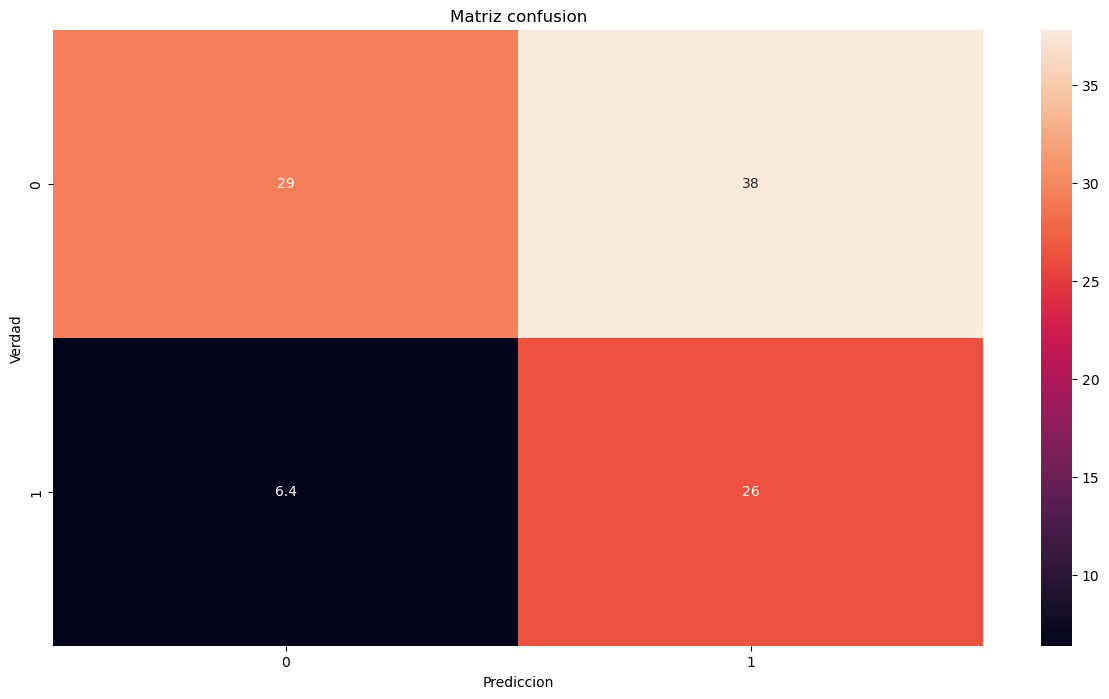

In [55]:
cm(y_test, y_pred_rfc2)
cm(y_test, y_pred_rfc2)/cm(y_test, y_pred_rfc2).sum()*100
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test, y_pred_rfc2)/cm(y_test, y_pred_rfc2).sum() * 100, 
               annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

# Matriz de confusion modelo sin umbral

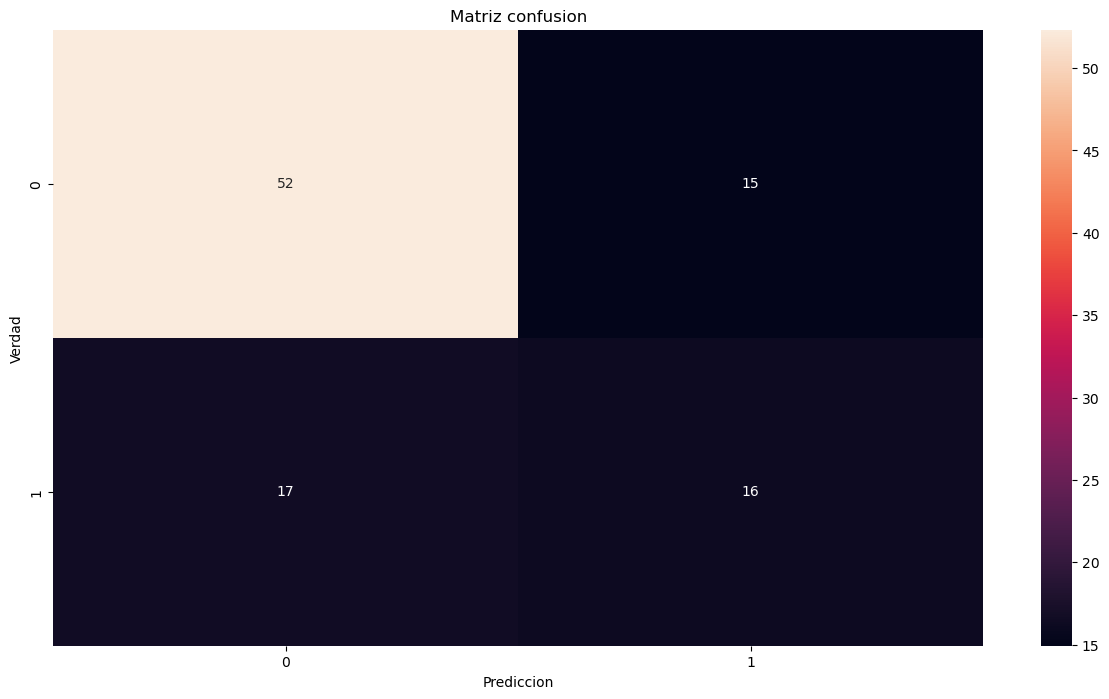

In [34]:
cm(y_test, y_pred_rfc)
cm(y_test, y_pred_rfc)/cm(y_test, y_pred_rfc).sum()*100
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test, y_pred_rfc)/cm(y_test, y_pred_rfc).sum() * 100, 
               annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

# Entreno el modelo y el escalador con todos los datos

In [59]:
fl2 = pd.read_csv("../data/ML/clean_data_for_ML.csv")

In [60]:
fl2 = fl2[fl2.duration.notna()]
fl2 = fl2.drop(columns = ['cod_flight_IATA','Relative_hum','Pressure','cod_airport_IATA'])
fl2['Delayed'] = fl2['arr_mins_of_delay'].apply(lambda x: 1 if x > 0 else 0)
fl2['week_num'] = fl2['week_num'].astype('object')
fl2 = fl2.drop(columns = ['arr_mins_of_delay'])
fl2=pd.get_dummies(fl2, columns = ['week_num','Condition','week_day','day_time','cod_airliner_IATA'], drop_first=True)


C:\Users\daarr\AppData\Local\Temp\ipykernel_22008\1826533291.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  fl2=pd.get_dummies(fl2, columns = ['week_num','Condition','week_day','day_time','cod_airliner_IATA'], drop_first=True)


In [61]:
X2 = fl2.drop('Delayed', axis=1)
y2 = fl2.Delayed

In [62]:
escalador_clasif = StandardScaler()    # inicia el normalizador
X2[['duration','Temperature', 'Wind', 'acc_Gusts','acc_bad_weather']] = escalador_clasif.fit_transform(X2[['duration','Temperature', 'Wind', 'acc_Gusts','acc_bad_weather']])   # transforma train

In [63]:
X2_resampled, y2_resampled = smote.fit_resample(X2, y2)

In [64]:
rfc_def = RandomForestClassifier(n_estimators=200,
                             min_samples_split=5,
                             min_samples_leaf=2,
                             n_jobs=8)


In [65]:
rfc_def.fit(X2_resampled, y2_resampled)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=8)

In [66]:
joblib.dump(rfc_def, 'modelo_clasificacion.joblib')

['modelo_clasificacion.joblib']

In [67]:
joblib.dump(escalador_clasif, 'escalador_clasificacion.joblib')

['escalador_clasificacion.joblib']

# Busqueda de Hiperparámetros

In [ ]:
# # Crear el clasificador RandomForestClassifier
# rfc = RandomForestClassifier(n_jobs=4, random_state=42)

# # Definir los parámetros que deseas ajustar
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Crear el objeto GridSearchCV
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='recall', n_jobs=2)

# # Ajustar el modelo a los datos
# grid_search.fit(X_resampled, y_resampled)

# # Imprimir los mejores hiperparámetros encontrados
# print("Mejores hiperparámetros:", grid_search.best_params_)

# # Imprimir la precisión del mejor modelo en el conjunto de prueba
# print("Precisión en el conjunto de prueba:", grid_search.best_estimator_.score(X_test, y_test))